<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:black;'>
    BlueMath - HyTCWaves
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:black;'>
    Non-stationary SWAN: vortex winds, <u>multiple synthetic</u> TC (north hemisphere)
</p>

<hr size="5"/>

<span style='font-family: times, arial; font-size:14pt; font-weight:bold; color:black;'> Table of Contents </span>

* [1. Load data (from preprocessing nb)](#1.-Load-data-(from-preprocessing-nb))


* [2. SWAN project](#2.-SWAN-project)
    * [2.1 SWAN main mesh](#2.1-SWAN-main-mesh)
    * [2.2 SWAN nested mesh](#2.2-SWAN-nested-mesh)
    * [2.3 SWAN case parameters](#2.3-SWAN-case-parameters)
    * [2.4 SWAN input: storm track, no waves](#2.4-SWAN-input:-storm-track,-no-waves)


* [3. Plot site configuration](#3.-Plot-site-configuration)


* [4. SWAN WRAP](#4.-SWAN-WRAP)
    * [4.1 Build cases](#4.1-Build-cases)
        * [Plot input: Vortex winds](#Plot-input:-Vortex-winds)
        * [Plot input: Grafiti maximum winds](#Plot-input:-Grafiti-maximum-winds)
    * [4.2 Run cases](#4.2-Run-cases)
        * [Plot output: Hsig](#Plot-output:-Hsig)
        * [Plot output: Grafiti maximum Hsig](#Plot-output:-Grafiti-maximum-Hsig)
        * [Plot output: Control Point time series](#Plot-output:-Control-Point-time-series)
    * [4.3 Extract output](#4.3-Extract-output)

<br>

<div class="alert alert-block alert-warning">
    
<b>Info:</b> this notebook imports SWAN input data (from preprocessing nb), defines SWAN configuration and meshes, builds and runs SWAN case. </div>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', 'hywaves'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import track_site_parameters

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_matrix_input, \
plot_case_output_points, plot_matrix_grafiti


##  **1. Load data (from preprocessing nb)**

In [2]:
site = 'Kwajalein'

# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', 'data'))
p_input = op.join(p_data, 'sites', site)

# load shoreline
np_shore = np.load(op.join(p_input, 'shore_{0}.npy'.format(site)))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_input, 'depth_{0}.nc'.format(site)))

# load storms
n_subset = 500
subset = pd.read_pickle(op.join(p_input, 'subset_r2_{0}_mda{1}.pkl'.format(site, n_subset)))


In [3]:
# define TCs parameters
pmin = subset['pmin'].values
vmean = subset['vmean'].values/1.872  # from [km/h] to [kt]
delta = subset['delta'].values
gamma = subset['gamma'].values


In [4]:
subset.loc[0:9]

,pmin,vmean,delta,gamma
0,1012.01010,33.316098,19.013635,91.117622
1,871.18487,29.840639,133.962326,99.632408
2,1007.30000,17.923800,197.239326,190.938650
3,981.12195,90.844576,142.976133,87.340486
4,989.07350,13.511197,138.651534,75.447247
5,906.00187,27.557653,14.425146,95.800984
6,994.93949,73.195070,236.878097,167.500540
7,995.71626,6.170056,304.869945,23.320465
8,1004.00000,7.732835,302.335273,224.452929
9,988.17164,82.976306,36.066059,109.164640


##  **2. SWAN project**

In [5]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_03_syn_mda'                  # project name

sp = SwanProject(p_proj, n_proj)

# some optional data (will be used at plotting)
sp.shore = np_shore  # project shoreline


###  **2.1 SWAN main mesh**

In [6]:
# get variables from bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]
depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
res = 0.136  # (15km = 0.136º)  
main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),

}

sp.set_main_mesh(main_mesh)


###  **2.2 SWAN nested mesh (optional)**

In [7]:
# lets cut inputh depth to a smaller area
xds_bathy_nest = xds_bathy.sel(
    lon = slice(165, 170),
    lat = slice(7, 10),
)

# get variables from bathymetry 
lon = xds_bathy_nest.lon.values[:]
lat = xds_bathy_nest.lat.values[:]
depth = xds_bathy_nest.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
mesh_nest = SwanMesh()

# depth grid description (input bathymetry grid)
mesh_nest.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
mesh_nest.dg_idla = 3

# depth value (from file)
mesh_nest.depth = depth

# computational grid description
res_nest = 0.04545

mesh_nest.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res_nest),
    'myc': int((lat[-1]-lat[0])/res_nest),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res_nest),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res_nest),

}

# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest])


###  **2.3 SWAN case parameters**

In [8]:

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    
    'output_deltt': '30 MIN',
    
    'output_points_x': [167.7336],
    'output_points_y': [8.66686],

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)


###  **2.4 SWAN input: storm track, no waves**

In [9]:
# target coordinates
target = 'Kwajalein'
x0, y0 = 167.73, 8.72

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]

    
# generate interpolated storms track list (within the target area)

r2 = 4      # radii from TC parameters 
date_ini = '2020-01-01 00:00'
st_list, we_list = [], []

for (pm, vm, de, ga) in zip(pmin, vmean, delta, gamma):

    # computational time step [min] following Vmean criteria: 
    # if vmean < 20km/h  dt_comp=20' 
    # if vmean > 20km/h  dt_comp=10' 
    if vm*1.852 < 20:      dt_comp = 20
    elif vm*1.852 >= 20:   dt_comp = 10

    st = track_site_parameters(dt_comp, pm, vm, de, ga, x0, y0, 
                               lon[0], lon[-1], lat[0], lat[-1], r2, date_ini)

    # [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
    st.attrs['override_dtcomp'] = '{0} MIN'.format(dt_comp)


    # time array for SWAN case input
    time = pd.date_range(date_ini, periods=st.shape[0], freq='{0}min'.format(dt_comp))

    # generate empty wave event
    we = pd.DataFrame(index=time, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
    we['level'] = 0
    we['tide'] = 0

    st_list.append(st)
    we_list.append(we)   


##  **3. Plot site configuration**

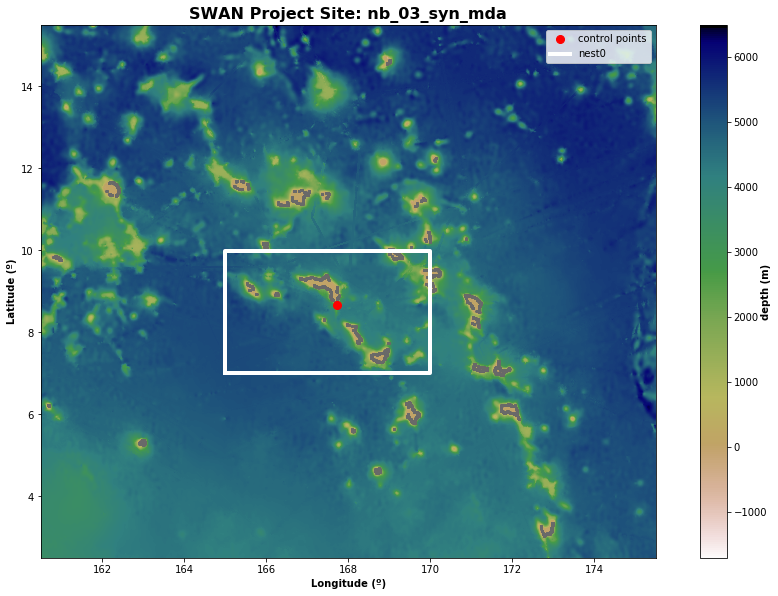

In [10]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp);


##  **4. SWAN WRAP**

In [10]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


###  **4.1 Build cases**

In [16]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases(we_list, storm_track_list=st_list[0:9], make_waves=False, make_levels=False)


CASE 0000 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0001 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0002 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0003 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0004 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0005 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0006 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0007 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0008 - compute_deltc, wind_deltinp override with storm track: 20 MIN


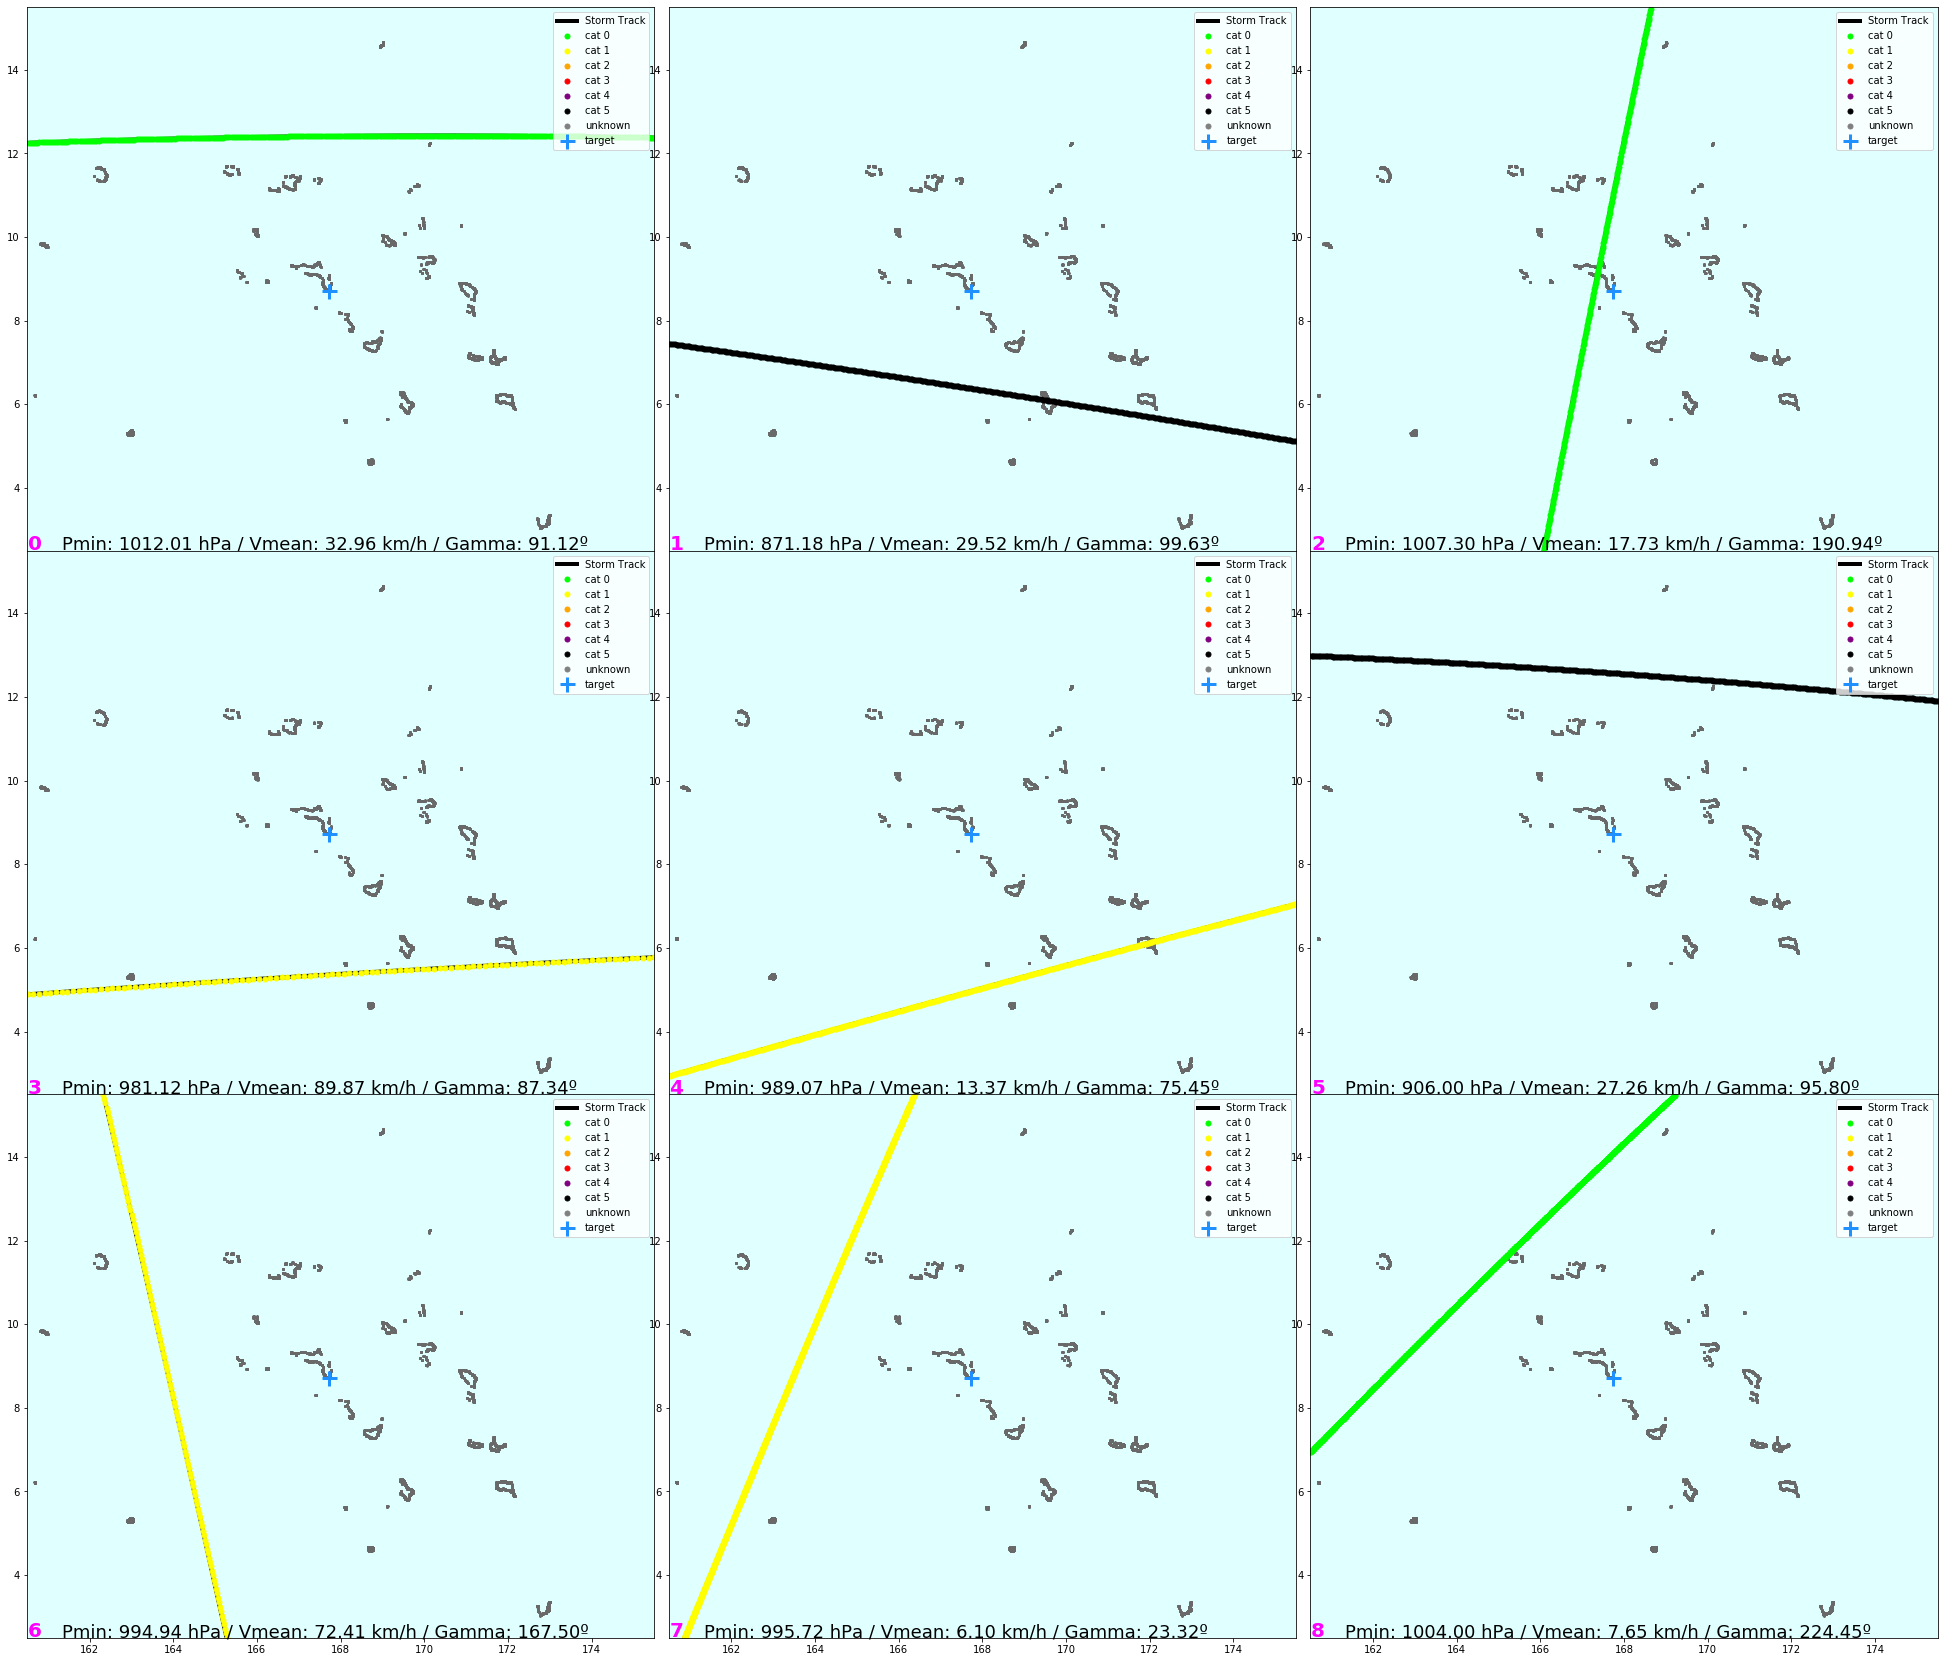

In [11]:
plot_matrix_input(sp, storm_track_list=st_list, case_ini=0, case_end=9)

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot input: Grafiti maximum winds

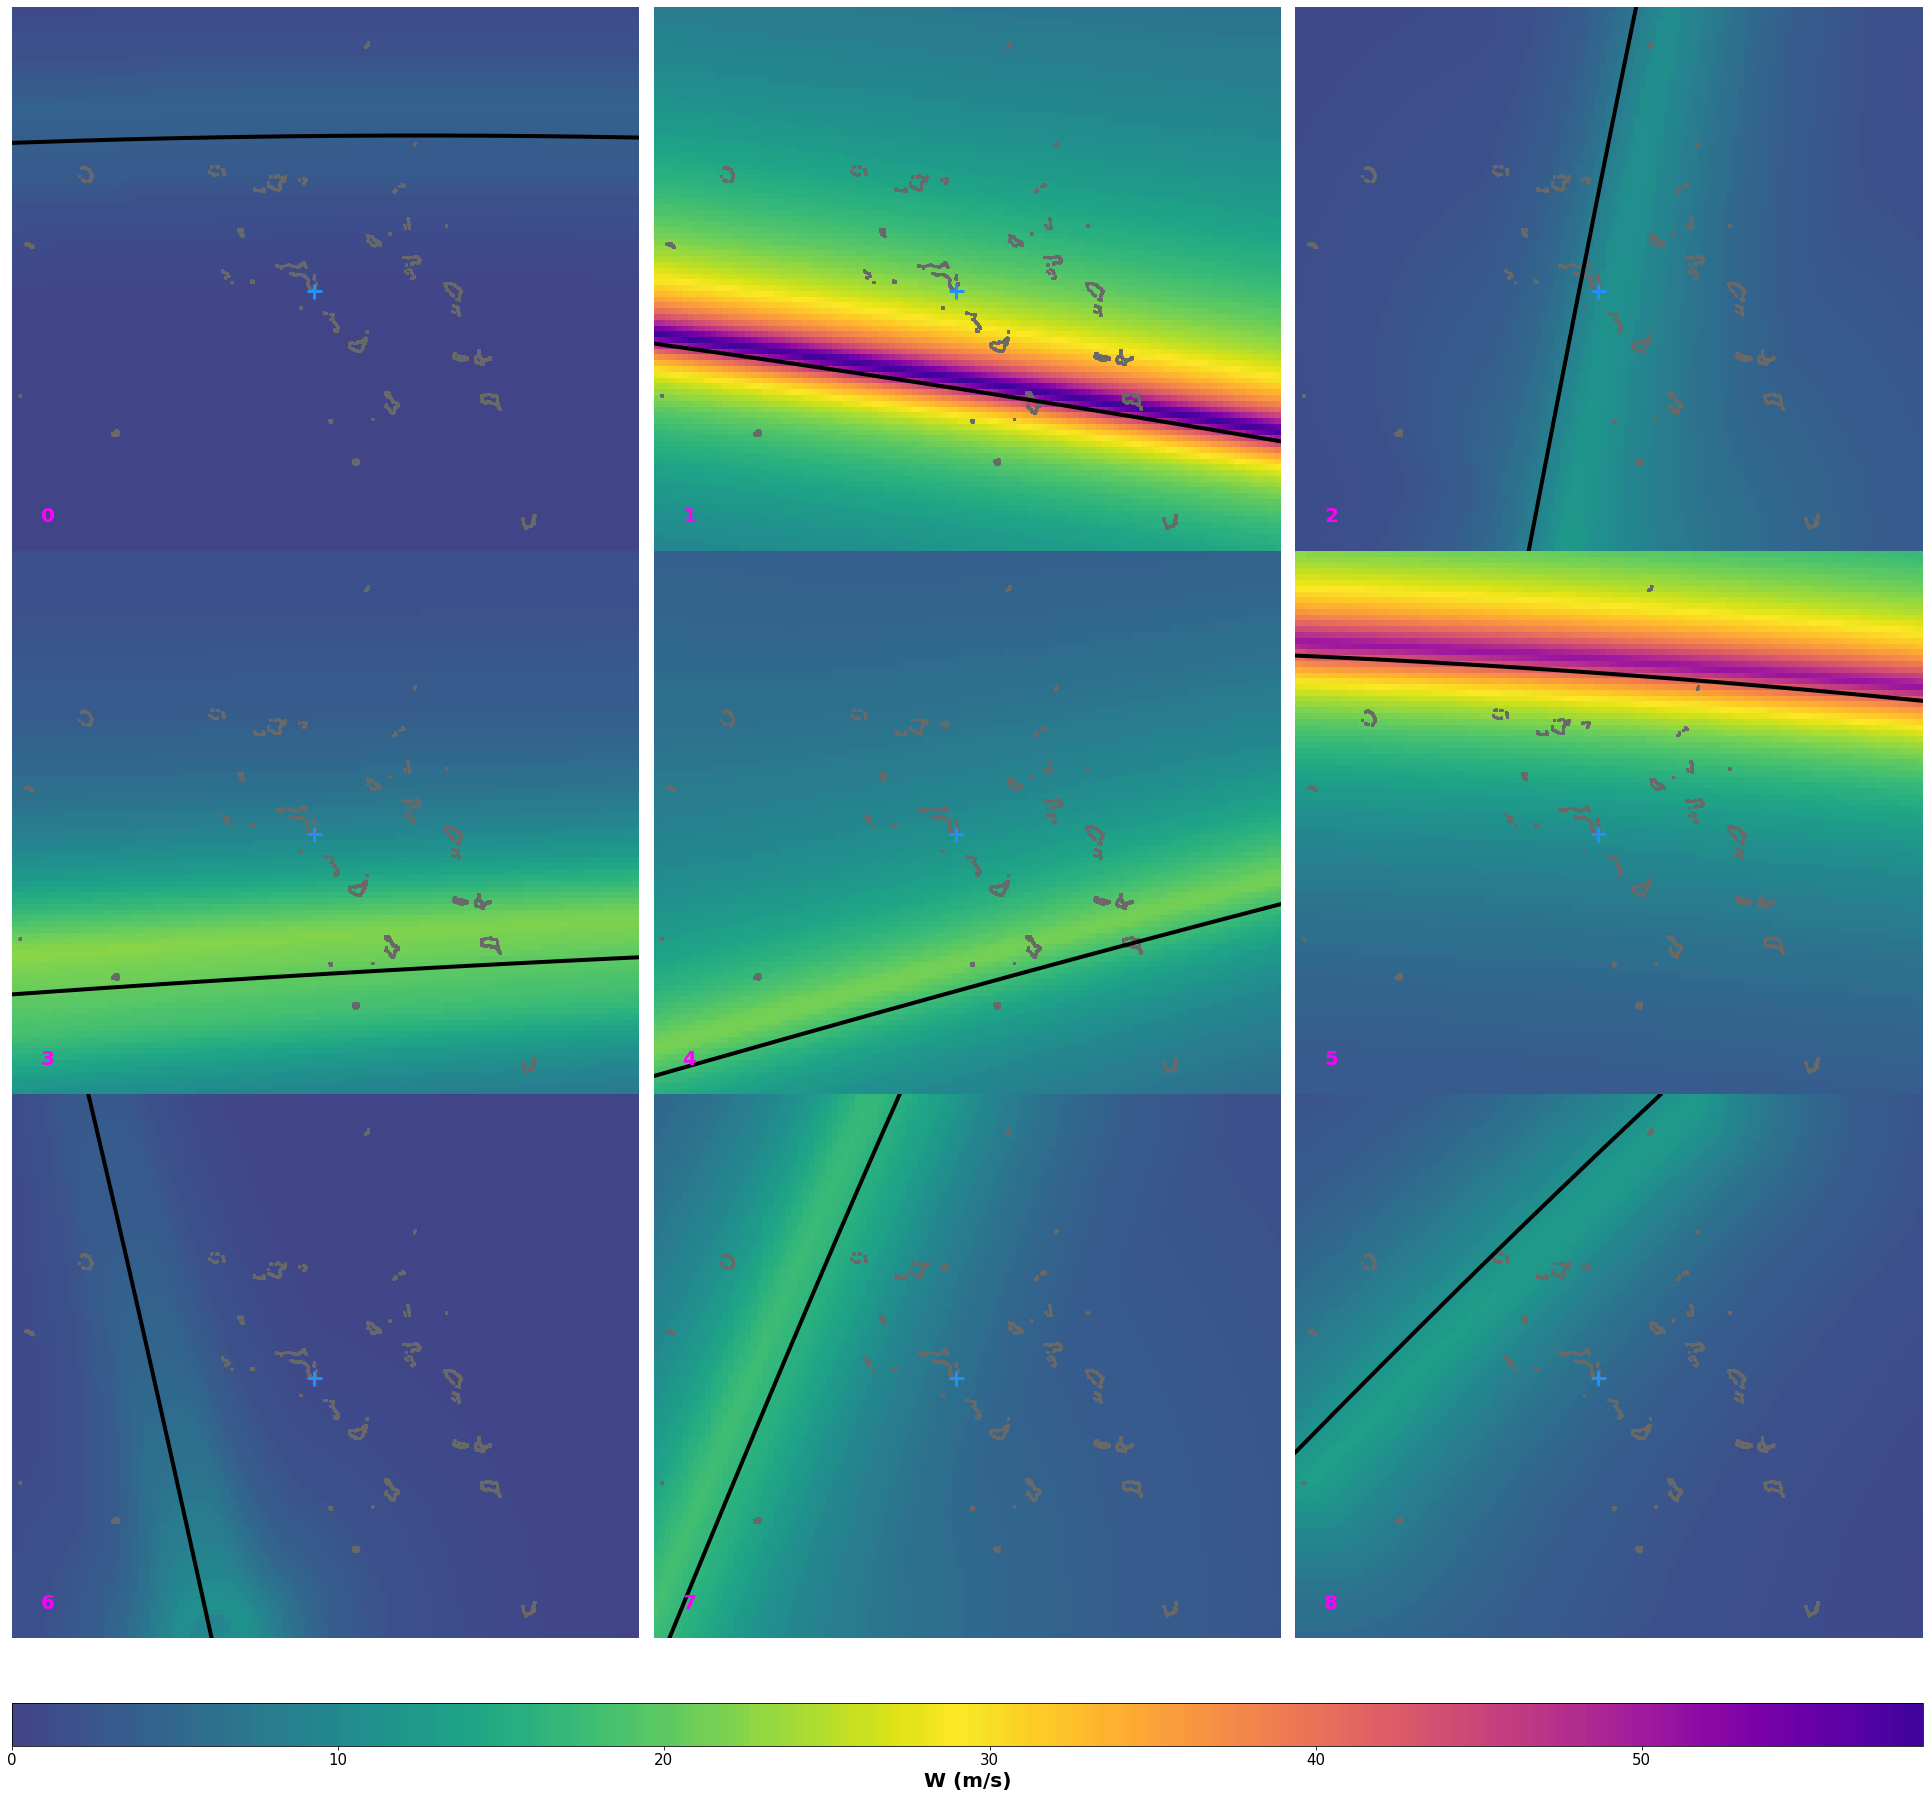

In [12]:
plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=0, case_end=9);

###  **4.2 Run cases**

In [17]:
sw.run_cases()

SWAN CASE: 0000 SOLVED
SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
SWAN CASE: 0006 SOLVED
SWAN CASE: 0007 SOLVED
SWAN CASE: 0008 SOLVED


#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Grafiti maximum Hsig

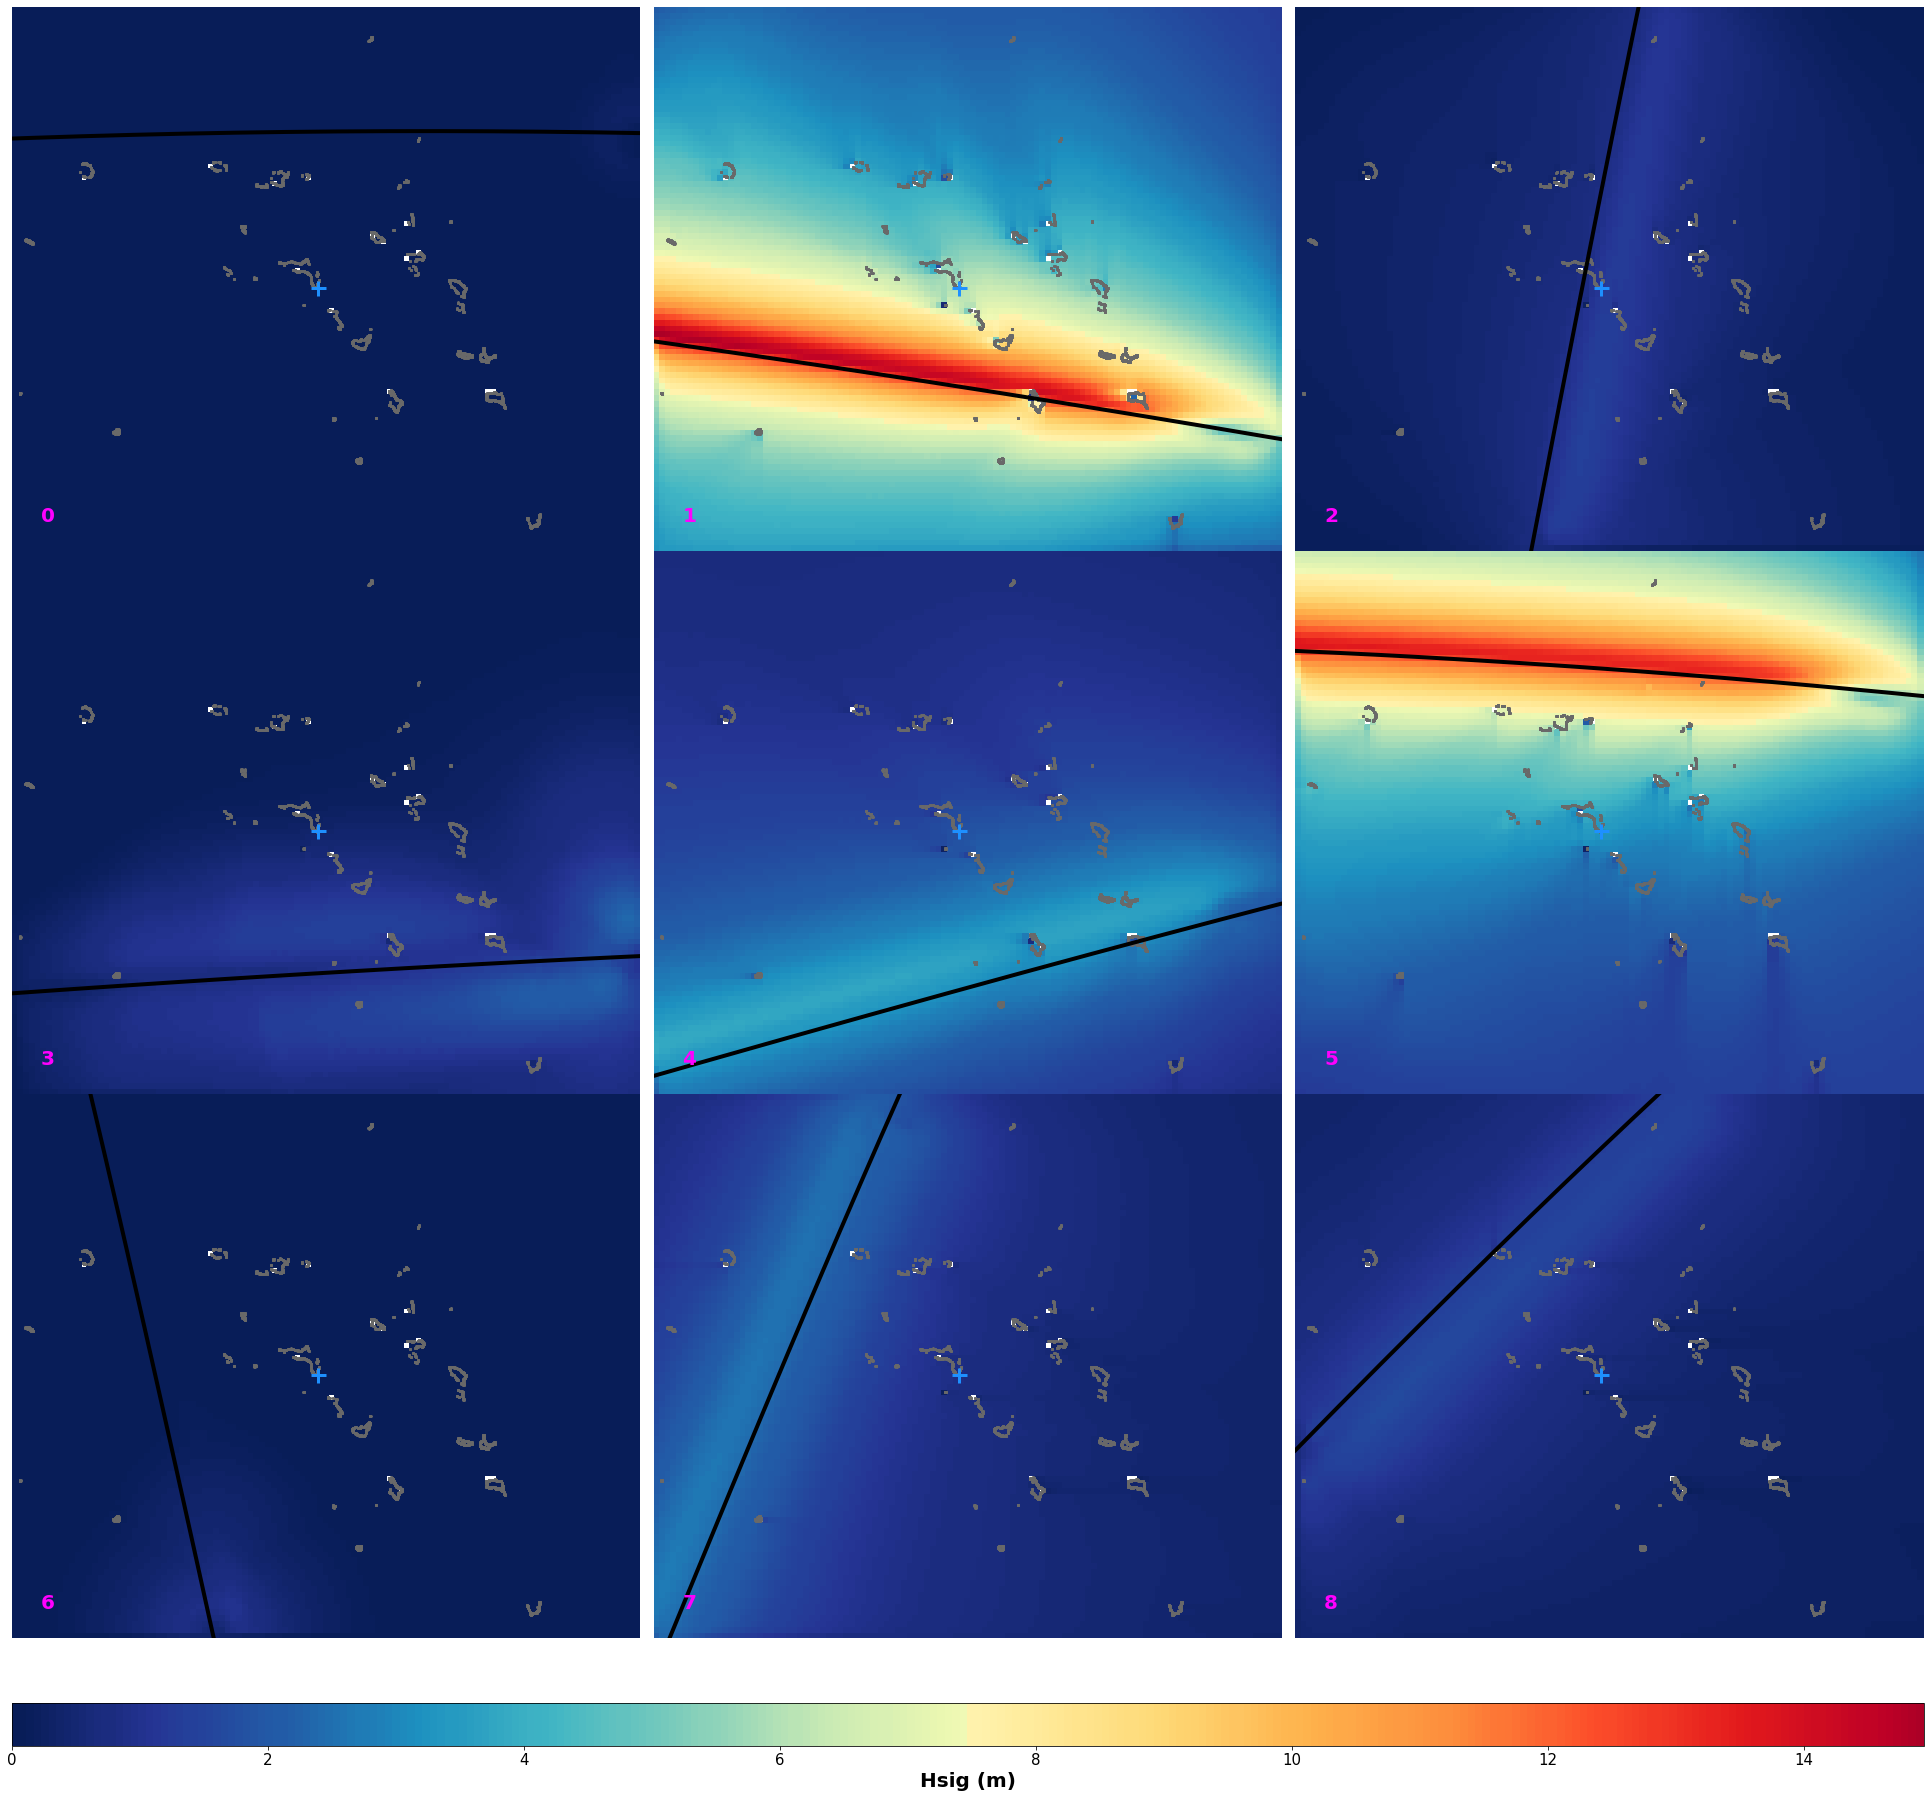

In [16]:
plot_matrix_grafiti(sw, 'Hsig', storm_track_list=st_list, case_ini=0, case_end=9);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Control Point time series

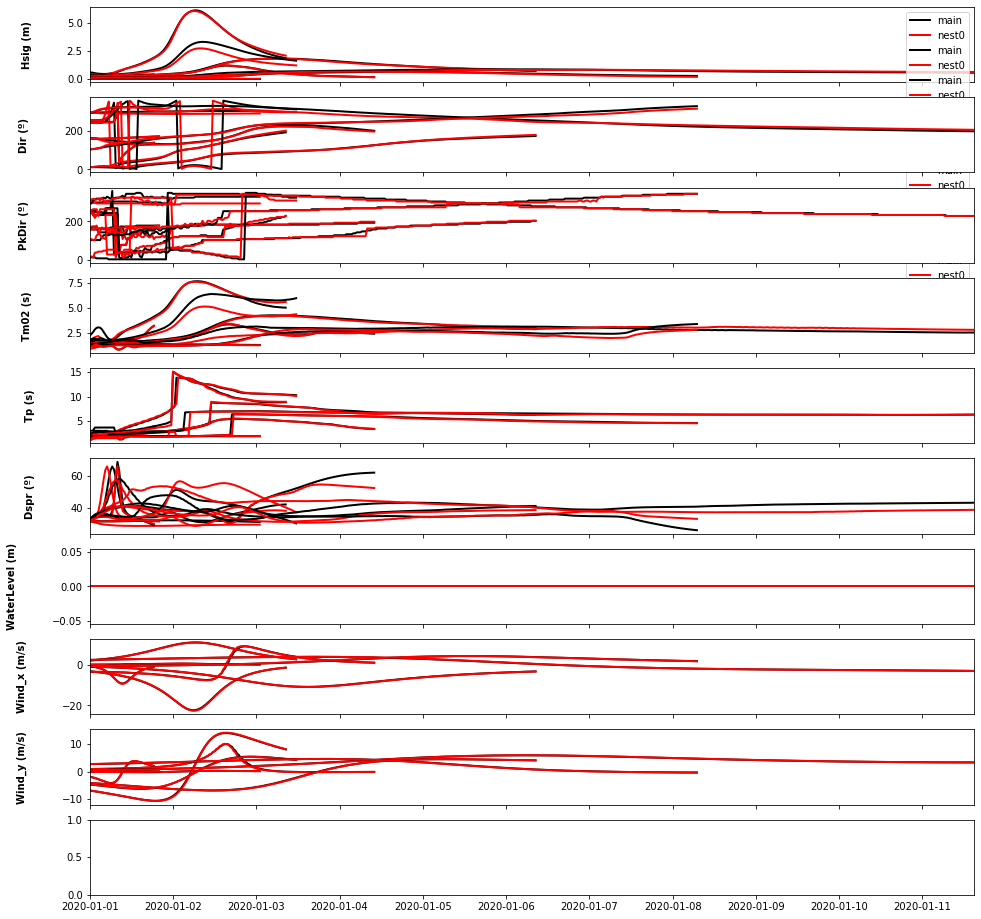

In [11]:
plot_case_output_points(sw, case_ini=0, case_end=9);

###  **4.3 Extract output**

####  **Mesh main**

In [12]:
output_main = sw.extract_output(case_ini=0, case_end=9)
print(output_main, '\n')

<xarray.Dataset>
Dimensions:     (case: 9, lat: 95, lon: 110, time: 571)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-11T15:00:00
  * lon         (lon) float64 160.5 160.6 160.8 160.9 ... 175.1 175.2 175.4
  * lat         (lat) float64 2.502 2.639 2.776 2.912 ... 15.09 15.22 15.36
  * case        (case) int64 0 1 2 3 4 5 6 7 8
Data variables:
    Hsig        (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    Dir         (case, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    PkDir       (case, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    Tm02        (case, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    Tp          (case, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    Dspr        (case, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan 



####  **Mesh nested**

In [14]:
output_nest = sw.extract_output(case_ini=0, case_end=9, mesh=mesh_nest)
print(output_nest, '\n')

<xarray.Dataset>
Dimensions:     (case: 9, lat: 65, lon: 109, time: 571)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-11T15:00:00
  * lon         (lon) float64 165.0 165.0 165.1 165.1 ... 169.9 169.9 170.0
  * lat         (lat) float64 7.002 7.048 7.094 7.14 ... 9.814 9.86 9.906 9.952
  * case        (case) int64 0 1 2 3 4 5 6 7 8
Data variables:
    Hsig        (case, time, lat, lon) float32 0.00014154417 ... nan
    Dir         (case, time, lat, lon) float32 299.59628 299.30078 ... nan nan
    PkDir       (case, time, lat, lon) float32 297.5 297.5 297.5 ... nan nan nan
    Tm02        (case, time, lat, lon) float32 1.4047022 1.4047436 ... nan nan
    Tp          (case, time, lat, lon) float32 1.9607034 1.960703 ... nan nan
    Dspr        (case, time, lat, lon) float32 31.507027 31.532816 ... nan nan
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan 



####  **Points (mesh main)**

In [13]:
output_pts = sw.extract_output_points(case_ini=0, case_end=9)
print(output_pts, '\n')

<xarray.Dataset>
Dimensions:         (case: 9, point: 1, time: 511)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 ... 2020-01-11T15:00:00
  * case            (case) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: point
Data variables:
    Hsig (m)        (case, point, time) float64 0.0005117 0.0005087 ... nan nan
    Dir (º)         (case, point, time) float64 297.0 297.2 297.5 ... nan nan
    PkDir (º)       (case, point, time) float64 297.5 297.5 297.5 ... nan nan
    Tm02 (s)        (case, point, time) float64 1.418 1.417 1.415 ... nan nan
    Tp (s)          (case, point, time) float64 1.961 1.961 1.96 ... nan nan nan
    Dspr (º)        (case, point, time) float64 31.51 31.5 31.49 ... nan nan nan
    WaterLevel (m)  (case, point, time) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    Wind_x (m/s)    (case, point, time) float64 0.07 0.07054 0.07612 ... nan nan
    Wind_y (m/s)    (case, point, time) float64 -0.1373 -0.1403 ... nan nan
    x_point         (cas